In [54]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv

import tensorflow as tf

In [182]:
run = 0

In [55]:
env = CliffWalkingEnv()
action_descriptions = { 0: 'up', 1: 'right', 2: 'down', 3: 'left' }

In [137]:
def plot_information(policies, values, qs):
    def plot_actions(data, title):
        fig, axes = plt.subplots(2, 2, figsize=(17, 7))
        fig.suptitle(title)
        for j in range(4):
            axes.flat[j].set_title(f'Action {action_descriptions[j]}')
            image = data[:, j].reshape((4, -1))
            im = axes.flat[j].imshow(image)
        fig.colorbar(im, ax=axes.ravel().tolist())

    plot_actions(policies, 'Policies')
    plt.show()
#     plot_actions(qs, 'Q values')
#     plt.show()
    
    fig = plt.figure(figsize=(17, 4))
    plt.imshow(values.reshape((4, -1)))
    plt.title('State values')
    plt.colorbar()
    plt.show()

In [263]:
def actionImages(tensor):
    tensor = tf.transpose(tf.reshape(tensor, (4, 12, 4, 1)), perm=[2, 0, 1, 3])
    images = {}
    for key, value in action_descriptions.items():
        images[value] = tf.expand_dims(tf.gather(tensor, key), 0)
        
    return images

In [345]:
class PolicyEstimator:
    def __init__(self, learning_rate, value_estimator, q_estimator, state, action):
        with tf.variable_scope("policy_estimator", reuse=tf.AUTO_REUSE):
            advantage = value_estimator.target

            every_state = tf.range(env.observation_space.n, dtype=tf.int32)
            one_hots = tf.one_hot(every_state, depth=env.observation_space.n)
            parameters = tf.layers.dense(
                one_hots,
                env.action_space.n,
                kernel_initializer=tf.zeros_initializer(),
                use_bias=False,
                name="parameters",
            )

            self.policy = tf.nn.softmax(parameters)
            self.action_probs = tf.squeeze(tf.gather_nd(self.policy, [[state]]), name='state_policy')
            self.picked_action_prob = tf.squeeze(tf.gather(self.action_probs, [action]))
            self.loss = -tf.log(self.picked_action_prob) * advantage

            self.optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step()
            )

            tf.summary.histogram(
                "parameters_kernel", tf.get_variable("parameters/kernel")
            )
            tf.summary.scalar("loss", self.loss)

            for name, image in actionImages(self.policy).items():
                tf.summary.image(name, image)

In [346]:
class ValueEstimator:
    def __init__(self, learning_rate, state, reward, next_state):
        with tf.variable_scope("value_estimator", reuse=tf.AUTO_REUSE):
            every_state = tf.range(env.observation_space.n, dtype=tf.int32)
            one_hots = tf.one_hot(every_state, depth=env.observation_space.n)

            self.values = tf.squeeze(
                tf.layers.dense(
                    one_hots,
                    1,
                    kernel_initializer=tf.zeros_initializer(),
                    use_bias=False,
                    name="parameters",
                )
            )

            self.prediction = tf.squeeze(tf.gather(self.values, state))
            next_prediction = tf.squeeze(tf.gather(self.values, next_state))
            self.target = next_prediction + reward

            tf.summary.scalar("value_estimator_target", self.target)
            tf.summary.scalar("value_estimator_prediction", self.prediction)
            self.loss = tf.squared_difference(self.prediction, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step()
            )

            tf.summary.histogram(
                "parameters_kernel", tf.get_variable("parameters/kernel")
            )
            tf.summary.scalar("loss", self.loss)
            tf.summary.image(
                "values",
                tf.transpose(tf.reshape(self.values, [1, 12, 4, 1]), perm=[0, 2, 1, 3]),
            )

In [347]:
class QEstimator:
    def __init__(self, learning_rate, state, action, reward, next_state):
        sa_to_index = lambda s, a: s * env.action_space.n + a
        depth = env.action_space.n * env.observation_space.n

        with tf.variable_scope("q_estimator", reuse=tf.AUTO_REUSE):
            every_sa = tf.range(
                env.action_space.n * env.observation_space.n, dtype=tf.int32
            )
            one_hots = tf.one_hot(every_sa, depth=every_sa.shape[0])

            self.outputs = tf.squeeze(
                tf.layers.dense(
                    one_hots,
                    1,
                    kernel_initializer=tf.zeros_initializer(),
                    use_bias=False,
                )
            )

            self.prediction = tf.squeeze(
                tf.gather(self.outputs, sa_to_index(state, action))
            )
            next_predictions = tf.squeeze(
                tf.gather(
                    self.outputs,
                    tf.range(
                        sa_to_index(next_state, 0),
                        sa_to_index(next_state, env.action_space.n),
                    ),
                )
            )

            target = tf.reduce_max(next_predictions) + reward
            self.loss = tf.squared_difference(self.prediction, target)

            optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step()
            )

            for name, image in actionImages(self.outputs).items():
                tf.summary.image(name, image)

In [348]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.train.create_global_step()

p_state = tf.placeholder(tf.int32, [])
p_action = tf.placeholder(tf.int32, [])
p_next_state = tf.placeholder(tf.int32, [])
p_next_action = tf.placeholder(tf.int32, [])
p_reward = tf.placeholder(tf.float32)

value_estimator = ValueEstimator(0.1, p_state, p_reward, p_next_state)
q_estimator = QEstimator(0.5, p_state, p_action, p_reward, p_next_state)
policy_estimator = PolicyEstimator(0.01, value_estimator, q_estimator, p_state, p_action)

writer = tf.summary.FileWriter(f"summaries/run_{run}", tf.get_default_graph())
run += 1
all_summaries = tf.summary.merge_all()
global_step = 0

In [349]:
sess.run(tf.global_variables_initializer())
episode_lengths = []
total_rewards = [0]
policies = np.empty((env.observation_space.n, env.action_space.n), dtype=np.float32)
values = np.empty(env.observation_space.n, dtype=np.float32)
qs = np.empty_like(policies)

for i in range(400):
    state = env.reset()
    
    done = False
    total_reward = 0
    episode_length = 0

    while not done:
        action_probs = sess.run(policy_estimator.action_probs, {p_state: state})
        action = np.random.choice(len(action_probs), p=action_probs)
        
        next_state, reward, done, _ = env.step(action)
        
        total_reward += reward
        episode_length += 1

        policies[state], values[state], qs[
            state, action
        ], summary, global_step, _, _, _ = sess.run(
            [
                policy_estimator.action_probs,
                value_estimator.prediction,
                q_estimator.prediction,
                all_summaries,
                tf.train.get_global_step(),
                value_estimator.train_op,
                q_estimator.train_op,
                policy_estimator.train_op,
            ],
            {
                p_state: state,
                p_action: action,
                p_reward: reward,
                p_next_state: next_state,
                p_next_action: action,
            },
        )
        print(f"\rStep {episode_length} @ Episode {i} ({total_rewards[-1]})", end="")
        writer.add_summary(summary, global_step)

        state = next_state

    episode_lengths.append(episode_length)
    total_rewards.append(total_reward)



Step 79379 @ Episode 51 (-617)

KeyboardInterrupt: 

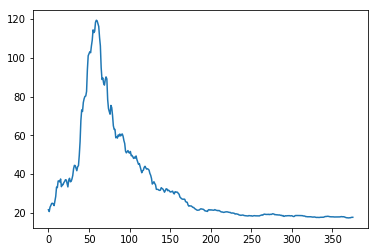

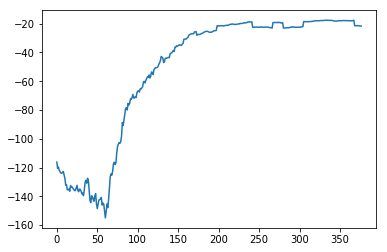

In [344]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(episode_lengths, 25))
plt.figure()
plt.plot(running_mean(total_rewards, 25))